In [5]:
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['font.size'] = 14
mpl.rcParams['font.family'] = 'arial'

import torch
import torch.nn as nn
from torch.utils.data import Dataset

class GaitDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        return self.features[idx, ...], self.labels[idx]

class GaitGRUModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, layer_dim: int, output_dim: int,
                 reduced_chnl: int, kernel_size: int, stride: int):
        super().__init__()

        # channel weighting layer
        self.channel_weights = nn.Linear(input_dim, reduced_chnl)

        # sequence length reduction layer
        self.seq_reduction_conv = nn.Conv1d(reduced_chnl, reduced_chnl,
                                            kernel_size=kernel_size,
                                            stride=stride,
                                            padding=1)

        self.gru = nn.GRU(reduced_chnl, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x: torch.Tensor):
        x = x.permute(0, 2, 1) # permute to [batch, seq_len, num_channels]

        batch_size, seq_len, num_channels = x.shape
        x = x.reshape([batch_size * seq_len, num_channels])
        x = self.channel_weights(x)
        x = x.reshape([batch_size, -1, seq_len])
        x = self.seq_reduction_conv(x)
        x = x.permute(0, 2, 1) # permute back to (batch, seq_len, num_channels) for rnn

        x, _ = self.gru(x)
        x = self.fc(x[:, -1, :])
        out = self.softmax(x)
        return out

**Load model**

In [7]:
model = PCPGRUModel(input_dim=16, hidden_dim=64, layer_dim=1, output_dim=4, reduced_chnl=4, kernel_size=2500, stride=2500)
model.load_state_dict(torch.load('pcp_model.pt'))
model.eval()  # Set the model to evaluation mode
print(model)

channel_weights = model.channel_weights.weight.data.numpy()

PCPGRUModel(
  (channel_weights): Linear(in_features=16, out_features=4, bias=True)
  (seq_reduction_conv): Conv1d(4, 4, kernel_size=(2500,), stride=(2500,), padding=(1,))
  (gru): GRU(4, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=4, bias=True)
  (softmax): LogSoftmax(dim=1)
)


**Visualization**

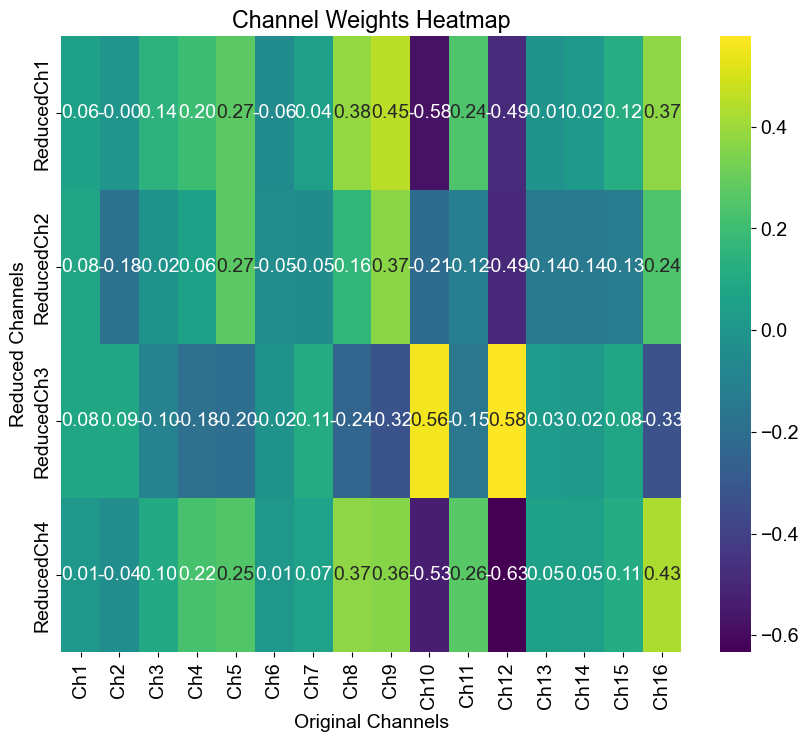

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming channel_weights shape is [4, 16], we need to select or aggregate the data for visualization if needed
# Directly visualizing the weight matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(channel_weights, annot=True, fmt=".2f", cmap="viridis",
            xticklabels=[f"Ch{i+1}" for i in range(16)],
            yticklabels=[f"ReducedCh{i+1}" for i in range(4)])
plt.title("Channel Weights Heatmap")
plt.xlabel("Original Channels")
plt.ylabel("Reduced Channels")
plt.show()

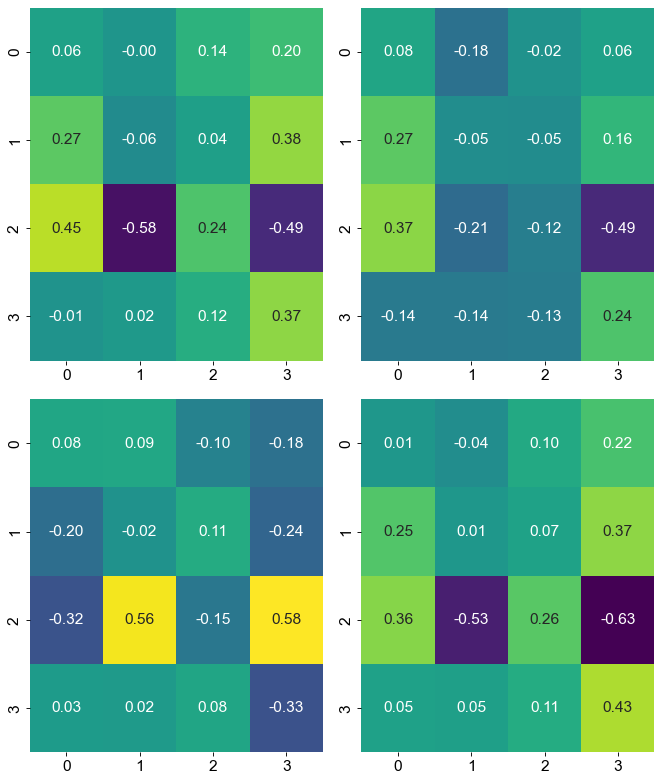

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=80)

# Assuming channel_weights is already defined and reshaped if needed
# Normalize the colormap across all subplots
norm = Normalize(vmin=channel_weights.min(), vmax=channel_weights.max())

# Create a colormap
cmap = "viridis"

for i in range(4):  # For each of the 4 reduced channels
    ax = axes.ravel()[i]
    # Create the heatmap, but do not automatically add a colorbar
    sns.heatmap(channel_weights[i].reshape(4,4), ax=ax, cmap=cmap, annot=True, fmt=".2f",
                cbar=False, norm=norm, xticklabels=True, yticklabels=True)
    # ax.set_title(f'Reduced Channel {i+1}')
    # ax.set_xlabel('Original Channel Segment')
    # ax.set_ylabel('Segment Division')

# # Create an axis on the right side of the figure
# # This will be used for the colorbar
# fig.subplots_adjust(right=0.8)
# cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])

# # Create the colorbar
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# sm.set_array([])
# fig.colorbar(sm, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to make room for the colorbar
plt.show()
